In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import PIL
import cv2
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [5]:
# importing tensorflow_hub to transfer models from
import tensorflow_hub as hub

# Transfering Entire MobileNet model
- Documentations and code snippets can be found on tensorflow_hub
- MobileNet takes 224 x 224 pixels as input size

In [14]:
# Loading the full model

Full_Mobile_Net_model = keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/edgetpu/vision/mobilenet-edgetpu-v2/m/1',input_shape = (224,224,3))
])

OSError: SavedModel file does not exist at: C:\Users\SOURAV\AppData\Local\Temp\tfhub_modules\29eb136f865333b56581c9fa9f7a01eb1431f909\{saved_model.pbtxt|saved_model.pb}

In [7]:
# loading the classes in Mobilenet

with open('./datasets/MobileNet_classes.txt','r') as f:
    labels = f.read().splitlines()
    
label_dict = dict(enumerate(labels))

- testing a goldfish image to see if Mobilenet works properly or not

In [8]:
# loading the image and resizing and rescaling
goldfish = cv2.imread('./Images/goldfish.jpg')
goldfish = cv2.resize(goldfish,(224,224))
goldfish = goldfish/255
goldfish.shape

(224, 224, 3)

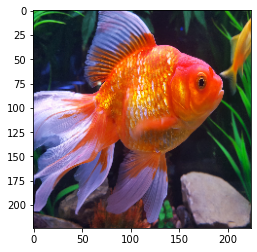

In [12]:
# visualization
plt.imshow(goldfish[:,:,::-1])

In [10]:
#  increasing a dimention as input to a cnn is given as array of images
np.array([goldfish]).shape

(1, 224, 224, 3)

In [13]:
# prediction
y_pred = Full_Mobile_Net_model.predict(np.array([goldfish]))
label_dict[np.argmax(y_pred)]

NameError: name 'Full_Mobile_Net_model' is not defined

# Transfer learning

### Creating our flowers dataset

In [9]:
flower_lables = ['daisy','dandelion','roses','sunflowers','tulips']

In [10]:
file_path = pathlib.Path('./datasets/flower_photos/')
file_path

WindowsPath('datasets/flower_photos')

In [11]:
X = []
y = []

for i in range(len(flower_lables)):
    for j in file_path.glob(f'./{flower_lables[i]}/*'):
        image = cv2.imread(str(j))
        image = cv2.resize(image,(224,224))
        image = image/255
        
        X.append(image)
        y.append(i)

In [12]:
X = np.array(X)
y = np.array(y)

In [13]:
X.shape,y.shape

((3670, 224, 224, 3), (3670,))

In [14]:
# train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y,train_size=0.8,random_state=456)

### Transfer_learning

- here the link in hub.KerasLayer will change
- the last part will include 'feature-vector' meaning it will includeonly the hidden layer

In [15]:
model_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
transfer_model = hub.KerasLayer(model_url,input_shape = (224,224,3),trainable = False)

CNN = keras.Sequential([
    transfer_model,
    keras.layers.Dense(5,activation = 'softmax')
])

CNN.summary()

OSError: SavedModel file does not exist at: C:\Users\SOURAV\AppData\Local\Temp\tfhub_modules\145bb06ec3b59b08fb564ab752bd5aa222bfb50a\{saved_model.pbtxt|saved_model.pb}

In [25]:
CNN.compile(
    optimizer = 'adam',
    loss = keras.losses.sparse_categorical_crossentropy,
    metrics = ['acc']
)

In [26]:
CNN.fit(x_train,y_train,epochs=10)

Epoch 1/10
92/92 [==============================] - 61s 484ms/step - loss: 0.7963 - acc: 0.7047
Epoch 2/10
92/92 [==============================] - 46s 502ms/step - loss: 0.4024 - acc: 0.8566
Epoch 3/10
92/92 [==============================] - 47s 514ms/step - loss: 0.3109 - acc: 0.8965
Epoch 4/10
92/92 [==============================] - 48s 518ms/step - loss: 0.2628 - acc: 0.9206
Epoch 5/10
92/92 [==============================] - 48s 527ms/step - loss: 0.2247 - acc: 0.9332
Epoch 6/10
92/92 [==============================] - 55s 594ms/step - loss: 0.1968 - acc: 0.9441
Epoch 7/10
92/92 [==============================] - 66s 720ms/step - loss: 0.1761 - acc: 0.9537
Epoch 8/10
92/92 [==============================] - 56s 606ms/step - loss: 0.1541 - acc: 0.9636
Epoch 9/10
92/92 [==============================] - 48s 526ms/step - loss: 0.1373 - acc: 0.9676
Epoch 10/10
92/92 [==============================] - 48s 525ms/step - loss: 0.1247 - acc: 0.9731


In [27]:
CNN.evaluate(x_test,y_test)

23/23 [==============================] - 14s 515ms/step - loss: 0.3962 - acc: 0.8583


[0.39617910981178284, 0.8583106398582458]

In [28]:
y_pred = CNN.predict(x_test)
y_pred = [np.argmax(i) for i in y_pred]

23/23 [==============================] - 14s 497ms/step


Text(69.0, 0.5, 'y_predicted')

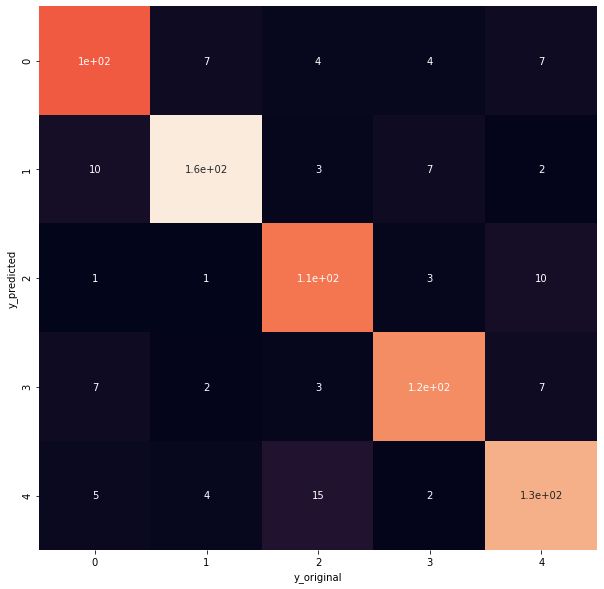

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,cbar = False)
plt.xlabel('y_original')
plt.ylabel('y_predicted')

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       126
           1       0.92      0.88      0.90       180
           2       0.82      0.88      0.85       128
           3       0.88      0.86      0.87       140
           4       0.84      0.84      0.84       160

    accuracy                           0.86       734
   macro avg       0.86      0.86      0.86       734
weighted avg       0.86      0.86      0.86       734

